# Adult Census Income

This dataset was taken from the <a href="https://archive.ics.uci.edu/ml/datasets/Adult">UCI Machine Learning Repository</a>. The goal is to predict whether income exceeds \$50K/yr based on census data.

The data was donated by Barry Becker in 1995 using the 1994 census database, so the information may not be as relevant now. However, I still think it's interesting to know education, salary, relationship, gender, and race over 20 years ago, and see how/if they have changed over time.

In [1]:
# Import libraries
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier

# Decision Tree Visual
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO  

/Users/sarinachen/.local/share/virtualenvs/Data_Practice-itP2Su3x/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Initial Data Cleaning

Some of the variables are not self-explanatory:
* `final_weight`: number of units in the target population that the responding unit represents
* `relationship`: the unit's role in the family
* `capital_gain` and `capital_loss`: income from investment sources other than wage/salary

In [2]:
# Import dataset
df = pd.read_csv("data/adult.data",header=None)
df.columns = ['age','work_class','final_weight', 'education','education_years','marital_status', 'occupation',
              'relationship','race','sex','capital_gain','capital_loss', 'hours_per_week', 'native_country','salary']
df.head()

,age,work_class,final_weight,education,education_years,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# Map education to number of years according to census
df[["education","education_years"]].drop_duplicates().sort_values(by="education_years")

,education,education_years
224,Preschool,1
160,1st-4th,2
56,5th-6th,3
15,7th-8th,4
6,9th,5
77,10th,6
3,11th,7
415,12th,8
2,HS-grad,9
10,Some-college,10


In [4]:
# Categorize education (ordinal)
edu_list = list(df[["education","education_years"]].drop_duplicates().sort_values(by="education_years")["education"])
ordered = pd.api.types.CategoricalDtype(ordered = True, categories = edu_list)
df["education"] = df["education"].astype(ordered)

Education ranges from preschool (1 year) to doctorate (16 years).

In [5]:
df.work_class.value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: work_class, dtype: int64

There are 1836 records that have an unknown (` ?`) working class.

In [6]:
df.marital_status.value_counts()

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital_status, dtype: int64

In [7]:
df.occupation.value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64

There are a lot of unknown (` ?`) occupations. Many of these records that have an unknown occupation also have an unknown working class. These people may have opted out from providing this information.

In [8]:
df.native_country.value_counts()

 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

Native country also has ` ?` values.

Based on the categorical data, `work_class`, `occupation`, and `native_country` have ` ?` values which should be changed to the mode.

In [9]:
df['work_class'] = df['work_class'].replace(' ?',' Private')
df['occupation'] = df['occupation'].replace(' ?',' Prof-specialty')
df['native_country'] = df['native_country'].replace(' ?',' United-States')

In [10]:
# Check the numerical data
df.describe()

,age,final_weight,education_years,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


* Both `capital_gain` and `hours_per_week` seem to have a limit. There are several records with these variables at the maximum. If the distributions for these don't look normal, then it may be better to change these to bins or categorical variables.
* Over 75% of the data don't have any `capital_gain` or `capital_loss`. 
* Most people work around 40 `hours_per_week`. The value is 40 between the 25th and 50th percentile. The value is 45 in the 75th percentile.


## Univariate Data Exploration

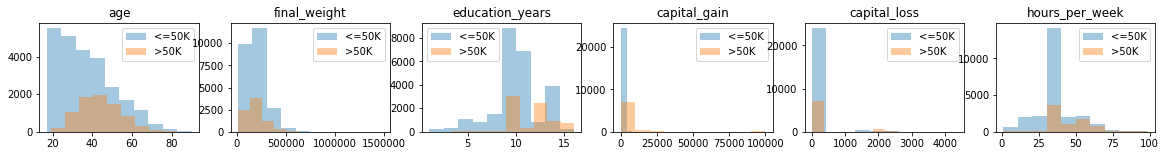

In [11]:
c = ['age','final_weight','education_years','capital_gain','capital_loss','hours_per_week']
fig, ax = plt.subplots(1, 6, figsize=(20,2))

for i in list(range(len(c))):
    plt.sca(ax[i]);
    d = df.query("salary == ' <=50K'")[c[i]]
    d.hist(grid=False, alpha=.4);
    d = df.query("salary == ' >50K'")[c[i]]
    d.hist(grid=False, alpha=.4);
    plt.legend(["<=50K",">50K"])
    plt.title(c[i]);

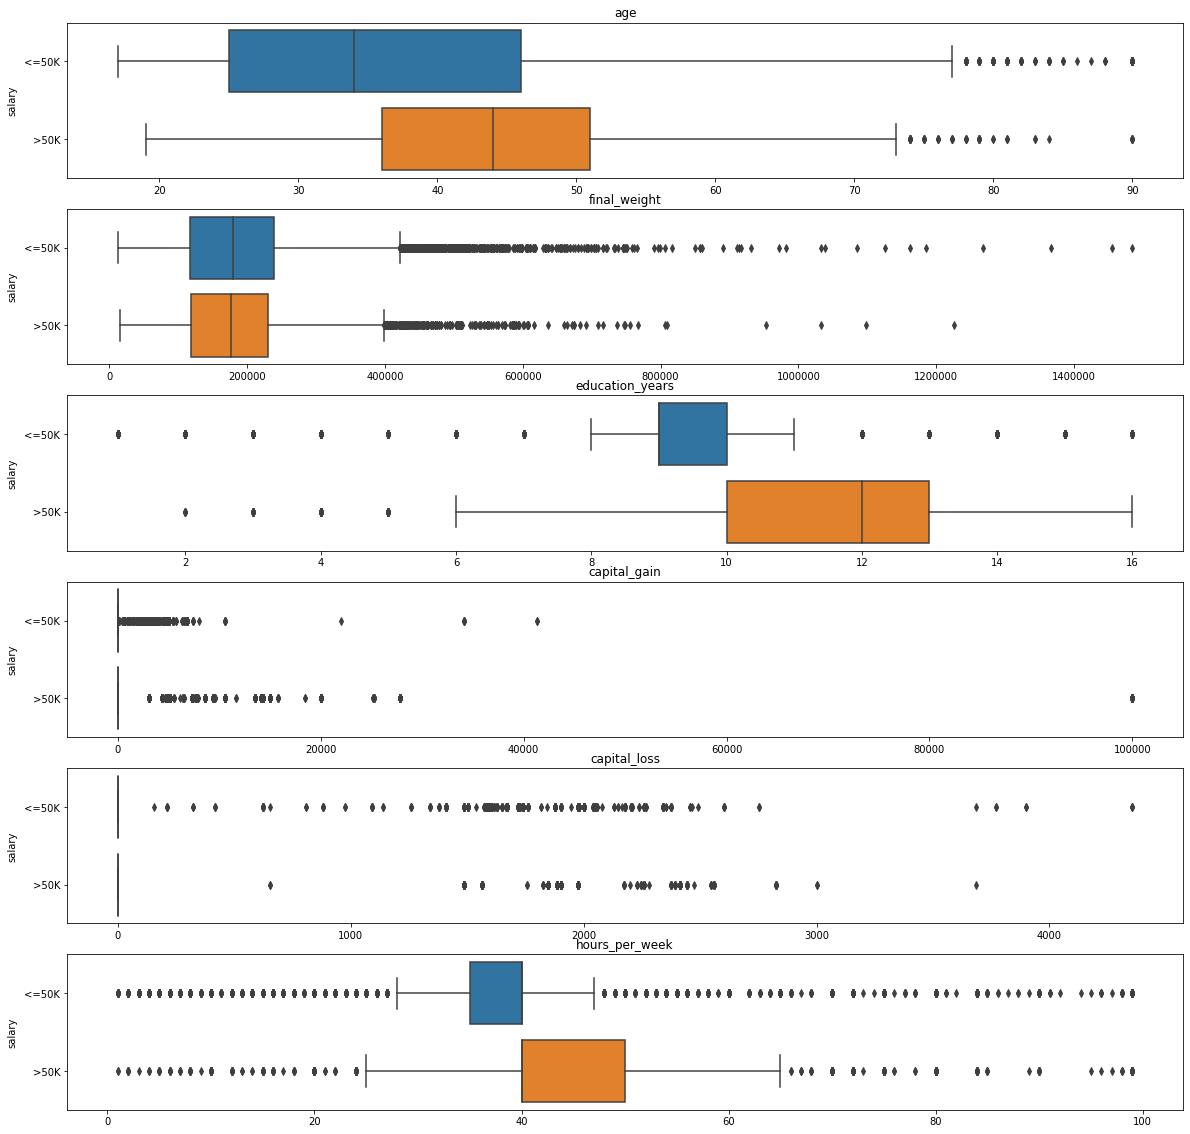

In [12]:
c = ['age','final_weight','education_years','capital_gain','capital_loss','hours_per_week']
fig, ax = plt.subplots(6, 1, figsize=(20,20))

for i in list(range(len(c))):
    plt.sca(ax[i]);
    sns.boxplot(data = df, x = c[i], y = "salary");
    plt.title(c[i]);
    plt.xlabel(None);
fig.subplots_adjust(hspace=.2)

* **Age:** The distribution is skewed right. Most people under 35 make a <= 50K salary. People who make > 50K salary tend to be above 40.
* **Final Weight:** The distribution is skewed right. Most weights are under 250,000.
* **Education:** Most of the population has values of 9, 10, and 13 (HS-grad, some college, and Bachelors). The majority of people making >50K have at least 10 years of education.
* **Capital Gain:** Most don't have other sources of income. 
* **Capital Loss:** Most don't have other losses. 
* **Hours per Week:** The majority work 40 hours per week. Besides the spike at the 40 hour mark, the distribution looks most normal out of all the numerical variables. Those with >50K salary work at least 40 hours, not less.

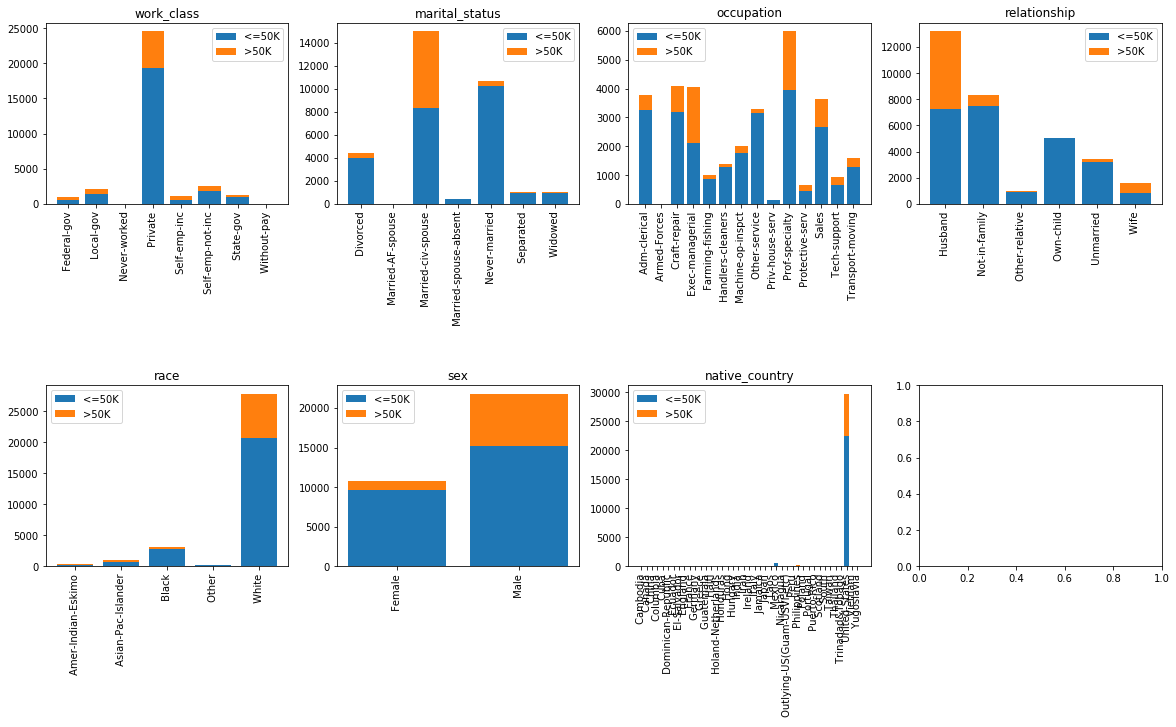

In [13]:
c = ["work_class","marital_status","occupation","relationship","race","sex","native_country"]
fig, ax = plt.subplots(2, 4, figsize=(20,10))

for i in list(range(len(c))):
    plt.sca(ax[i//4,i%4]);
    under = pd.DataFrame(df.query("salary == ' <=50K'").groupby(c[i]).count().iloc[:,0])
    over = pd.DataFrame(df.query("salary == ' >50K'").groupby(c[i]).count().iloc[:,0])
    d = under.join(over, how="outer", lsuffix="_under", rsuffix="_over")
    plt.bar(d.index, d.age_under)
    plt.bar(d.index, d.age_over, bottom = d.age_under);
    plt.legend(["<=50K",">50K"])
    plt.title(c[i]);
    plt.xticks(rotation="vertical");
fig.subplots_adjust(hspace=1)

* **Work Class:** The majority is private. Both salary bins seem to have similar distributions.
* **Marital Status:** In the group with >50K salary, most are married with a spouse (likely with a family). For those with <=50K salary, the majority are never married (maybe younger). 
* **Occupation:** Armed Forces and Priv-house-serv have very few people, seemingly all with <=50K salary. Most of the >50K salary population have occupations as Prof-specialty and Exec-managerial, which are pretty 50/50 between the two salary groups. 
* **Relationship:** Most people with >50K salary are married, and the majority are Husbands. There are a few who are own-child and this group makes <=50K salary.
* **Race:** The majority of the census is white. The most people who make >50K in salary are white.
* **Sex:** There are more males in this census, and the >50K salaried population are majority male.
* **Native Country:** The majority comes from United States.

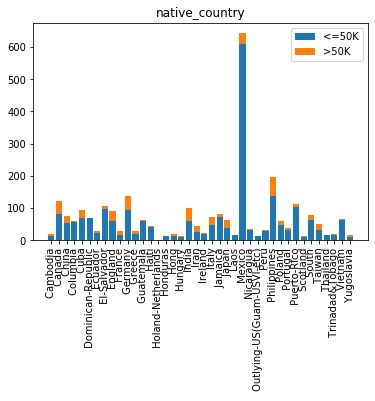

In [14]:
# Plot native country without the US
d = df[df.native_country != " United-States"]
under = pd.DataFrame(d.query("salary == ' <=50K'").groupby(c[i]).count().iloc[:,0])
over = pd.DataFrame(d.query("salary == ' >50K'").groupby(c[i]).count().iloc[:,0])
d = under.join(over, how="outer", lsuffix="_under", rsuffix="_over")
plt.bar(d.index, d.age_under)
plt.bar(d.index, d.age_over, bottom = d.age_under);
plt.legend(["<=50K",">50K"])
plt.title(c[i]);
plt.xticks(rotation="vertical");

* **Native Country (updated):** Besides the US, the group with the second highest count is Mexico, then Philipines. 

### Conclusions
* Workforce with >50K salary is mostly white, male, at least graduated from high school, work at least 40 hours per week, and are in a prof-specialty or exec-managerial position.
* Workforce with <=50K salary is likely the person is under 30 years old, female, did not graduate from college, works less than 40 hours per week, and was never married.

## Bivariate Data Exploration

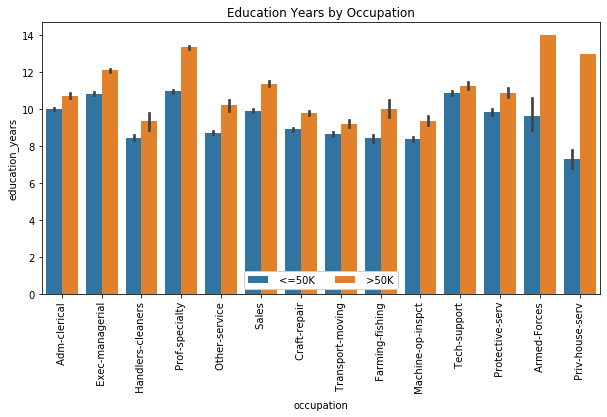

In [15]:
plt.figure(figsize = [10,5]);
sns.barplot(data = df, x = 'occupation', y = 'education_years', hue = 'salary')
plt.legend(loc = 8, ncol = 3, framealpha = 1);
plt.xticks(rotation=90);
plt.title('Education Years by Occupation');

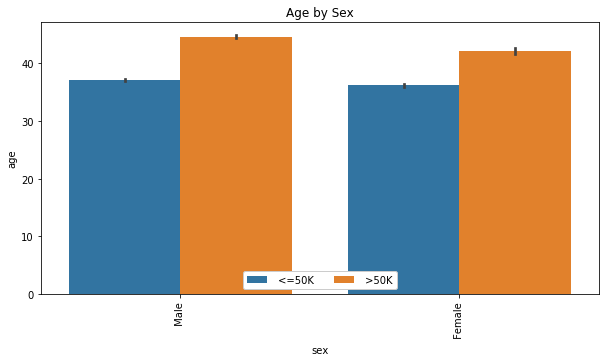

In [16]:
plt.figure(figsize = [10,5]);
sns.barplot(data = df, x = 'sex', y = 'age', hue = 'salary')
plt.legend(loc = 8, ncol = 3, framealpha = 1);
plt.xticks(rotation=90);
plt.title('Age by Sex');

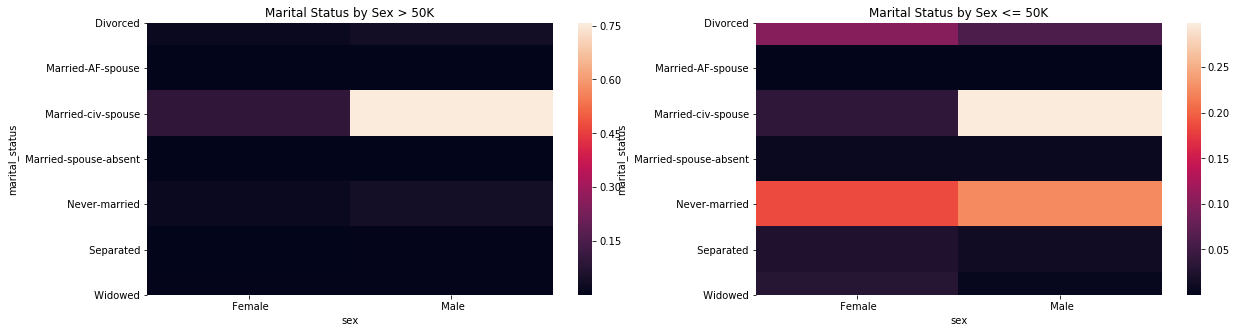

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

plt.sca(ax[0]);
ct_counts = df.query('salary == " >50K"').groupby(['sex', 'marital_status']).size()/df.query('salary == " >50K"').shape[0]
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'marital_status', columns = 'sex', values = 'count')
sns.heatmap(ct_counts);
plt.title('Marital Status by Sex > 50K');

plt.sca(ax[1]);
ct_counts = df.query('salary == " <=50K"').groupby(['sex', 'marital_status']).size()/df.query('salary == " <=50K"').shape[0]
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'marital_status', columns = 'sex', values = 'count')
sns.heatmap(ct_counts);
plt.title('Marital Status by Sex <= 50K');

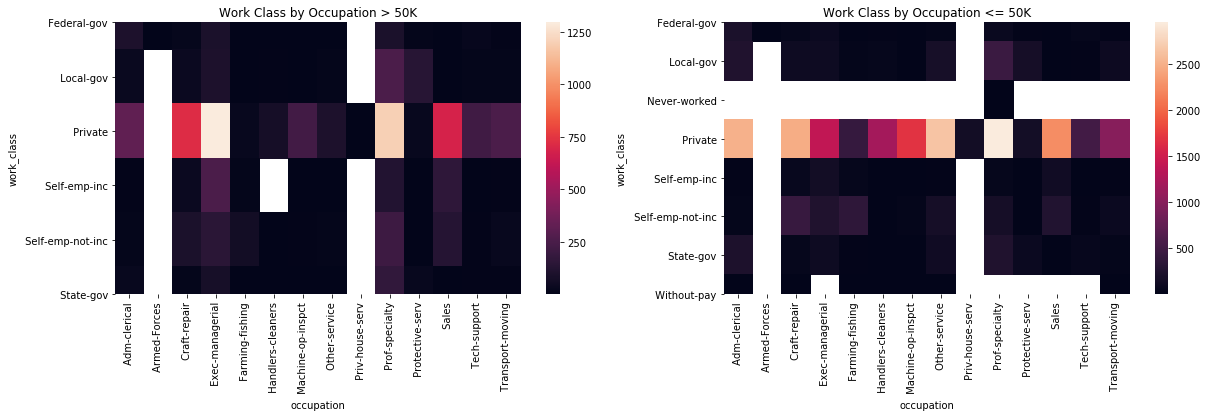

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

plt.sca(ax[0]);
ct_counts = df.query('salary == " >50K"').groupby(['work_class', 'occupation']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'work_class', columns = 'occupation', values = 'count')
sns.heatmap(ct_counts);
plt.title('Work Class by Occupation > 50K');

plt.sca(ax[1]);
ct_counts = df.query('salary == " <=50K"').groupby(['work_class', 'occupation']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'work_class', columns = 'occupation', values = 'count')
sns.heatmap(ct_counts);
plt.title('Work Class by Occupation <= 50K');

## Prediction using KNN 

The KNN model will be based on occupation, sex, race, education level, and relationship.

In [19]:
np.random.seed(42)

In [20]:
# creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers.
occupation_encoded=le.fit_transform(df.occupation)
sex_encoded=le.fit_transform(df.sex)
race_encoded=le.fit_transform(df.race)
relationship_encoded=le.fit_transform(df.relationship)
labels =le.fit_transform(df.salary)

# Combine features
features=list(zip(occupation_encoded,sex_encoded, race_encoded, list(df.education_years), relationship_encoded))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3) # 70% training and 30% test

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=50)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_true = y_test, y_pred= y_pred, labels = [0,1]))

Accuracy: 0.8237281195618794
[[6882  573]
 [1149 1165]]


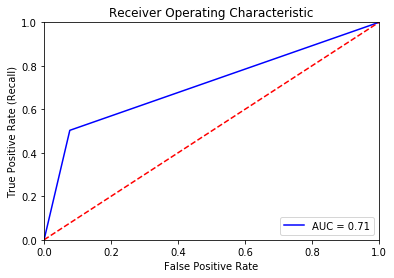

In [21]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.show()

This KNN model will be based on education level, sex, work, and relationship. Race was removed and work class replaced occupation.

In [22]:
# creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers.
work_encoded=le.fit_transform(df.work_class)
sex_encoded=le.fit_transform(df.sex)
race_encoded=le.fit_transform(df.race)
relationship_encoded=le.fit_transform(df.relationship)
labels =le.fit_transform(df.salary)

# Combine features
features=list(zip(list(df.education_years), sex_encoded, work_encoded, relationship_encoded))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3) # 70% training and 30% test

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=50)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_true = y_test, y_pred= y_pred, labels = [0,1]))

Accuracy: 0.8217831917289384
[[6922  522]
 [1219 1106]]


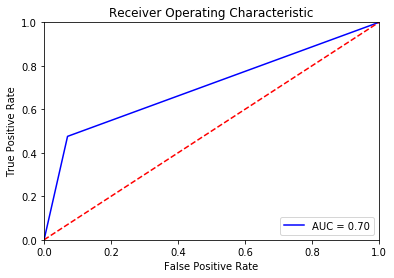

In [23]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Prediction using CART

The decision tree model will be based on occupation, sex, race, education level, and relationship.

In [24]:
# creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers.
occupation_encoded=le.fit_transform(df.occupation)
sex_encoded=le.fit_transform(df.sex)
race_encoded=le.fit_transform(df.race)
relationship_encoded=le.fit_transform(df.relationship)
labels =le.fit_transform(df.salary)

# Combine features
features=list(zip(occupation_encoded,sex_encoded, race_encoded, list(df.education_years), relationship_encoded))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=1)

# Create Decision Tree classifer object
dtc = DecisionTreeClassifier(max_leaf_nodes=64)

# Train Decision Tree Classifer
dtc.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = dtc.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_true = y_test, y_pred= y_pred, labels = [0,1]))

Accuracy: 0.8300747261746341
[[6994  556]
 [1104 1115]]


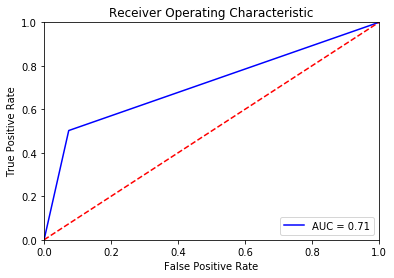

In [25]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

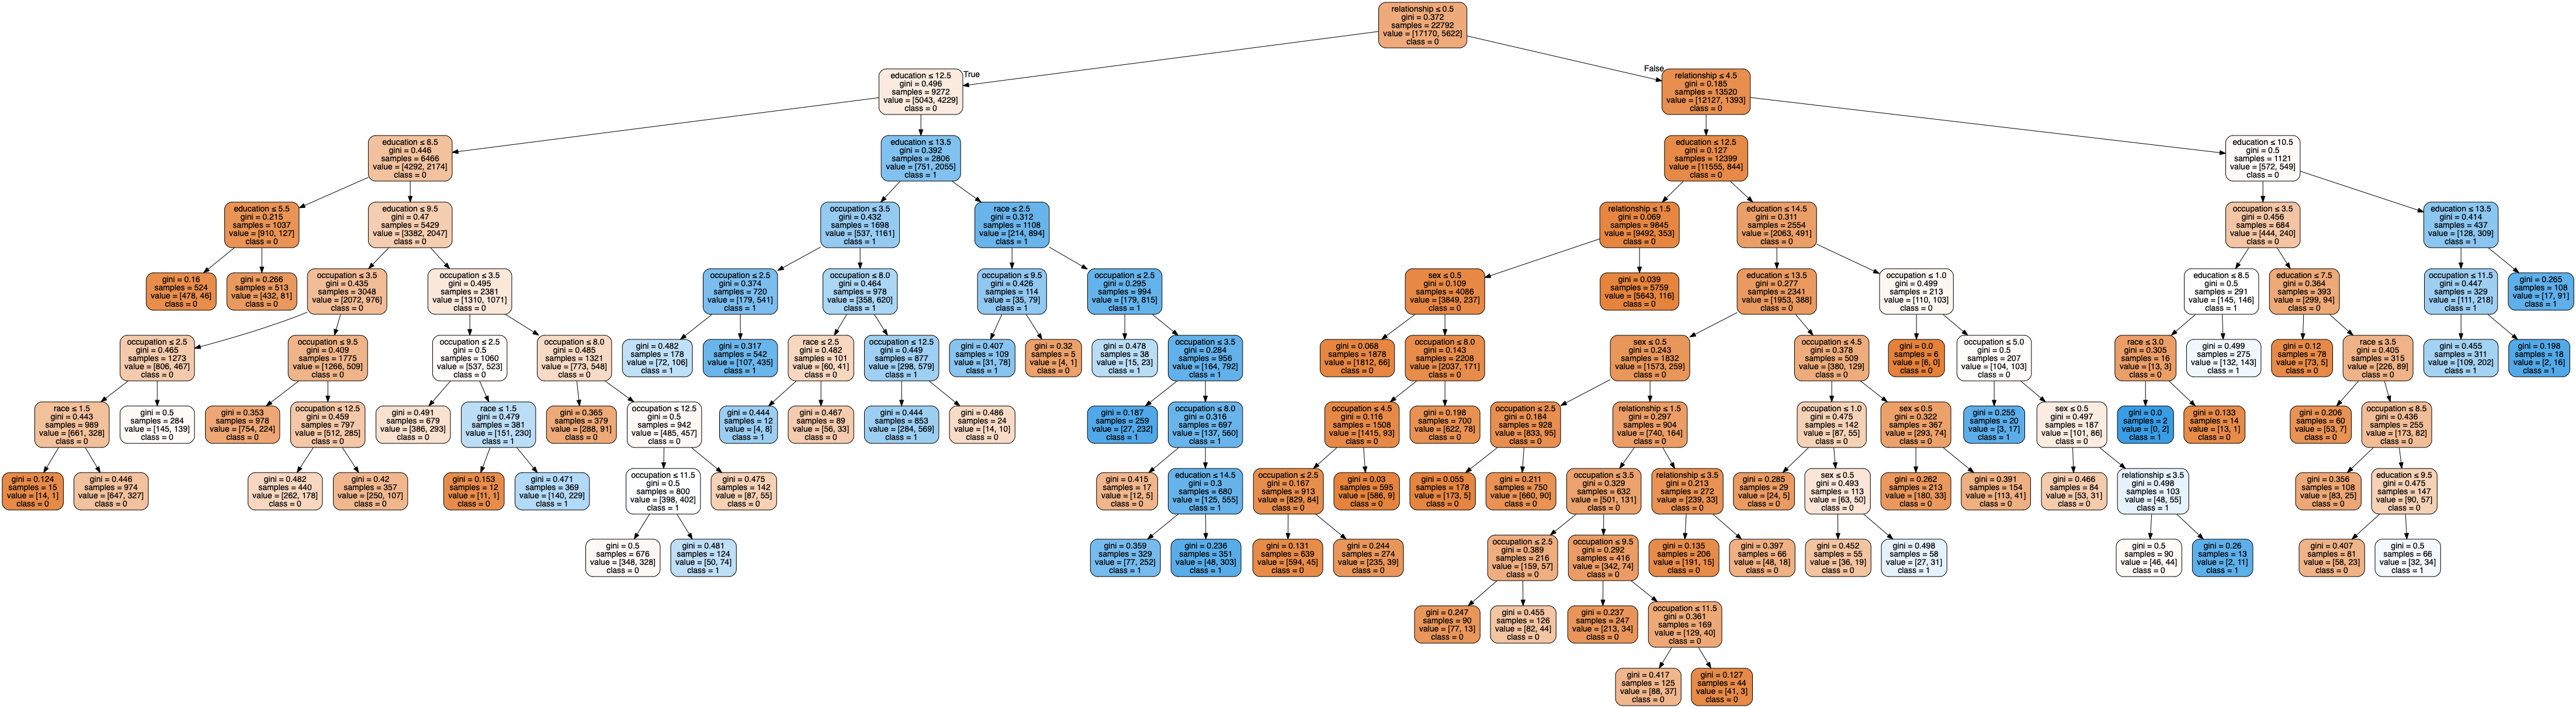

In [26]:
dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = ['occupation','sex','race','education','relationship'],class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

## Simplify Features

Although the models ran with ~80% success rate, the true positive rate is ~50% which is not good. The people who are predicted to have >= 50K salary is only 50/50. 

If we simplify some of the features, the model might run better...

Below is data frame structure as long as changes to be made:
* `age`: no change
* `sex`: no change
* `final_weight`: drop
* `education`: drop (duplicate of education_years)
* `eduation_years`: no change
* `marital_status`: married, single, other (based on % of groups being similar)
* `relationship`: combine husband and wife (if % are equal), other
* `work_class`: segment by private, government, self-employed, other (if % within groups make sense)
* `hours_per_week`: no change
* `occupation`: no change
* `race`: white, other
* `native_country`: United States, Europe, Asia, other OR United States, other
* `capital_gain`: no change
* `capital_loss`: no change

In [27]:
# this cell is essentially doing `data = df.copy()`
data = pd.DataFrame()

data['salary'] = le.fit_transform(df.salary)
data['age'] = df.age
data['sex'] = df.sex
data['education_years'] = df.education_years
data['marital_status'] = df.marital_status
data['relationship'] = df.relationship
data['work_class'] = df.work_class
data['occupation'] = df.occupation
data['hours_per_week'] = df['hours_per_week'] 
data['race'] = df.race
data['native_country'] = df.native_country
data['capital_gain'] = df.capital_gain
data['capital_loss'] = df.capital_loss

In [28]:
# See groups for marital status
data.groupby('marital_status').mean().salary

marital_status
 Divorced                 0.104209
 Married-AF-spouse        0.434783
 Married-civ-spouse       0.446848
 Married-spouse-absent    0.081340
 Never-married            0.045961
 Separated                0.064390
 Widowed                  0.085599
Name: salary, dtype: float64

The groups for `marital_status` will be the following:
* **Married:** Married-AF-spouse + Married-civ-spouse (44% have salary > 50K)
* **Not Together:** Divorced + Widowed + Separated (6 - 10%)
* **Single:** Never-Married (< 5%)

In [29]:
def marital_status_change(status):
    if status == ' Married-AF-spouse' or status == ' Married-civ-spouse':
        return 'married'
    elif status == ' Never-married':
        return 'single'
    else:
        return 'not_together'
    
data['marital_status'] = data['marital_status'].apply(lambda x: marital_status_change(x))

In [30]:
# See groups for relationship
data.groupby('relationship').mean().salary

relationship
 Husband           0.448571
 Not-in-family     0.103070
 Other-relative    0.037717
 Own-child         0.013220
 Unmarried         0.063262
 Wife              0.475128
Name: salary, dtype: float64

The groups for `relationship` will be the following:
* **married:** Husband + Wife
* **not_in_family:** All else

In [31]:
def relationship_change(status):
    if status == ' Husband' or status == ' Wife':
        return 'married'
    else:
        return 'not_in_family'
    
data['relationship'] = data['relationship'].apply(lambda x: relationship_change(x))

In [32]:
# See groups for work_class
data.groupby('work_class').mean().salary

work_class
 Federal-gov         0.386458
 Local-gov           0.294792
 Never-worked        0.000000
 Private             0.210093
 Self-emp-inc        0.557348
 Self-emp-not-inc    0.284927
 State-gov           0.271957
 Without-pay         0.000000
Name: salary, dtype: float64

The groups for `work_class` will be the following:
* **fed_gov:** Federal-gov
* **other_gov:** Local-gov + State-gov
* **private:** Private
* **self_emp_inc:** Self-emp-inc 
* **self_emp_not_inc:** Self-emp-not-inc (Did not combine the self-employed statuses due to difference in %)
* **none:** Without-pay + Never-worked

In [33]:
def work_class_change(status):
    if status == ' Federal-gov':
        return 'federal_gov'
    elif status == ' Local-gov' or status == ' State-gov':
        return 'other_gov'
    elif status == ' Private':
        return 'private'
    elif status == ' Self-emp-inc':
        return 'self_emp_inc'
    elif status == ' Self-emp-not-inc':
        return 'self_emp_not_inc'
    else:
        return 'none'
    
data['work_class'] = data['work_class'].apply(lambda x: work_class_change(x))

In [34]:
# See groups for race
data.groupby('race').mean().salary

race
 Amer-Indian-Eskimo    0.115756
 Asian-Pac-Islander    0.265640
 Black                 0.123880
 Other                 0.092251
 White                 0.255860
Name: salary, dtype: float64

The groups for `race` will be the following:
* **white:** White
* **asian:** Asian-Pac-Islander
* **other:** Black + Other + Amer-Indian-Eskimo (the total count of these data points are low)

In [35]:
def race_change(status):
    if status == ' White':
        return 'white'
    elif status == ' Asian-Pac-Islander':
        return 'asian'
    else:
        return 'other'
    
data['race'] = data['race'].apply(lambda x: race_change(x))

In [36]:
# See groups for native_country
data.groupby('native_country').mean().salary.sort_values()

native_country
 Holand-Netherlands            0.000000
 Outlying-US(Guam-USVI-etc)    0.000000
 Dominican-Republic            0.028571
 Columbia                      0.033898
 Guatemala                     0.046875
 Mexico                        0.051322
 Nicaragua                     0.058824
 Peru                          0.064516
 Vietnam                       0.074627
 Honduras                      0.076923
 El-Salvador                   0.084906
 Haiti                         0.090909
 Puerto-Rico                   0.105263
 Trinadad&Tobago               0.105263
 Portugal                      0.108108
 Laos                          0.111111
 Jamaica                       0.123457
 Ecuador                       0.142857
 Thailand                      0.166667
 South                         0.200000
 Poland                        0.200000
 Ireland                       0.208333
 Hungary                       0.230769
 United-States                 0.245925
 Scotland                

There are too many countries to group logically. These can be encoded in order.

In [37]:
x = pd.DataFrame(data.groupby('native_country').mean().salary.sort_values()).rank().reset_index()
data['native_country']=pd.merge(data['native_country'],x).salary

In [38]:
data.head()

,salary,age,sex,education_years,marital_status,relationship,work_class,occupation,hours_per_week,race,native_country,capital_gain,capital_loss
0,0,39,Male,13,single,not_in_family,other_gov,Adm-clerical,40,white,24.0,2174,0
1,0,50,Male,13,married,married,self_emp_not_inc,Exec-managerial,13,white,24.0,0,0
2,0,38,Male,9,not_together,not_in_family,private,Handlers-cleaners,40,white,24.0,0,0
3,0,53,Male,7,married,married,private,Handlers-cleaners,40,other,24.0,0,0
4,0,28,Female,13,married,married,private,Prof-specialty,40,other,24.0,0,0


## Model Comparison (raw features v. simplified features)

In [59]:
np.random.seed(42)

# creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers.
labels=le.fit_transform(df.salary)
work_class_encoded=le.fit_transform(df.work_class)
marital_encoded=le.fit_transform(df.marital_status)
occupation_encoded=le.fit_transform(df.occupation)
relationship_encoded=le.fit_transform(df.relationship)
race_encoded=le.fit_transform(df.race)
sex_encoded=le.fit_transform(df.sex)
native_country_encoded=le.fit_transform(df.native_country)

# Combine features
features=list(zip(
    list(df.age),
    work_class_encoded,
    list(df.education_years),
    marital_encoded,
    occupation_encoded,
    relationship_encoded,
    race_encoded,
    sex_encoded,
    list(df.capital_gain),
    list(df.capital_loss),
    list(df.hours_per_week),    
#     native_country_encoded
))

# Create Labels
labels = list(data.salary)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3) # 70% training and 30% test

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=50)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_true = y_test, y_pred= y_pred, labels = [0,1]))

Accuracy: 0.8422561162862114
[[6990  465]
 [1076 1238]]


In [60]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=1)

# Create Decision Tree classifer object
dtc = DecisionTreeClassifier(max_leaf_nodes=64)

# Train Decision Tree Classifer
dtc.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = dtc.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_true = y_test, y_pred= y_pred, labels = [0,1]))

Accuracy: 0.8578155389497389
[[6929  621]
 [ 768 1451]]


In [55]:
np.random.seed(42)

# creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers.
sex_encoded=le.fit_transform(data.sex)
marital_encoded=le.fit_transform(data.marital_status)
relationship_encoded=le.fit_transform(data.relationship)
work_class_encoded=le.fit_transform(data.work_class)
occupation_encoded=le.fit_transform(data.occupation)
race_encoded=le.fit_transform(data.race)

# Combine features
features=list(zip(
    list(data.age),
    sex_encoded,
    list(data.education_years),
    marital_encoded,
    relationship_encoded,
    work_class_encoded,
    occupation_encoded,
    list(data.hours_per_week),
    race_encoded,
#     list(data.native_country),
    list(data.capital_gain),
    list(data.capital_loss)
))

# Create Labels
labels = list(data.salary)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3) # 70% training and 30% test

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=50)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_true = y_test, y_pred= y_pred, labels = [0,1]))

Accuracy: 0.8422561162862114
[[7064  391]
 [1150 1164]]


In [56]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=1)

# Create Decision Tree classifer object
dtc = DecisionTreeClassifier(max_leaf_nodes=64)

# Train Decision Tree Classifer
dtc.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = dtc.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_true = y_test, y_pred= y_pred, labels = [0,1]))

Accuracy: 0.8647763332992118
[[7027  523]
 [ 798 1421]]


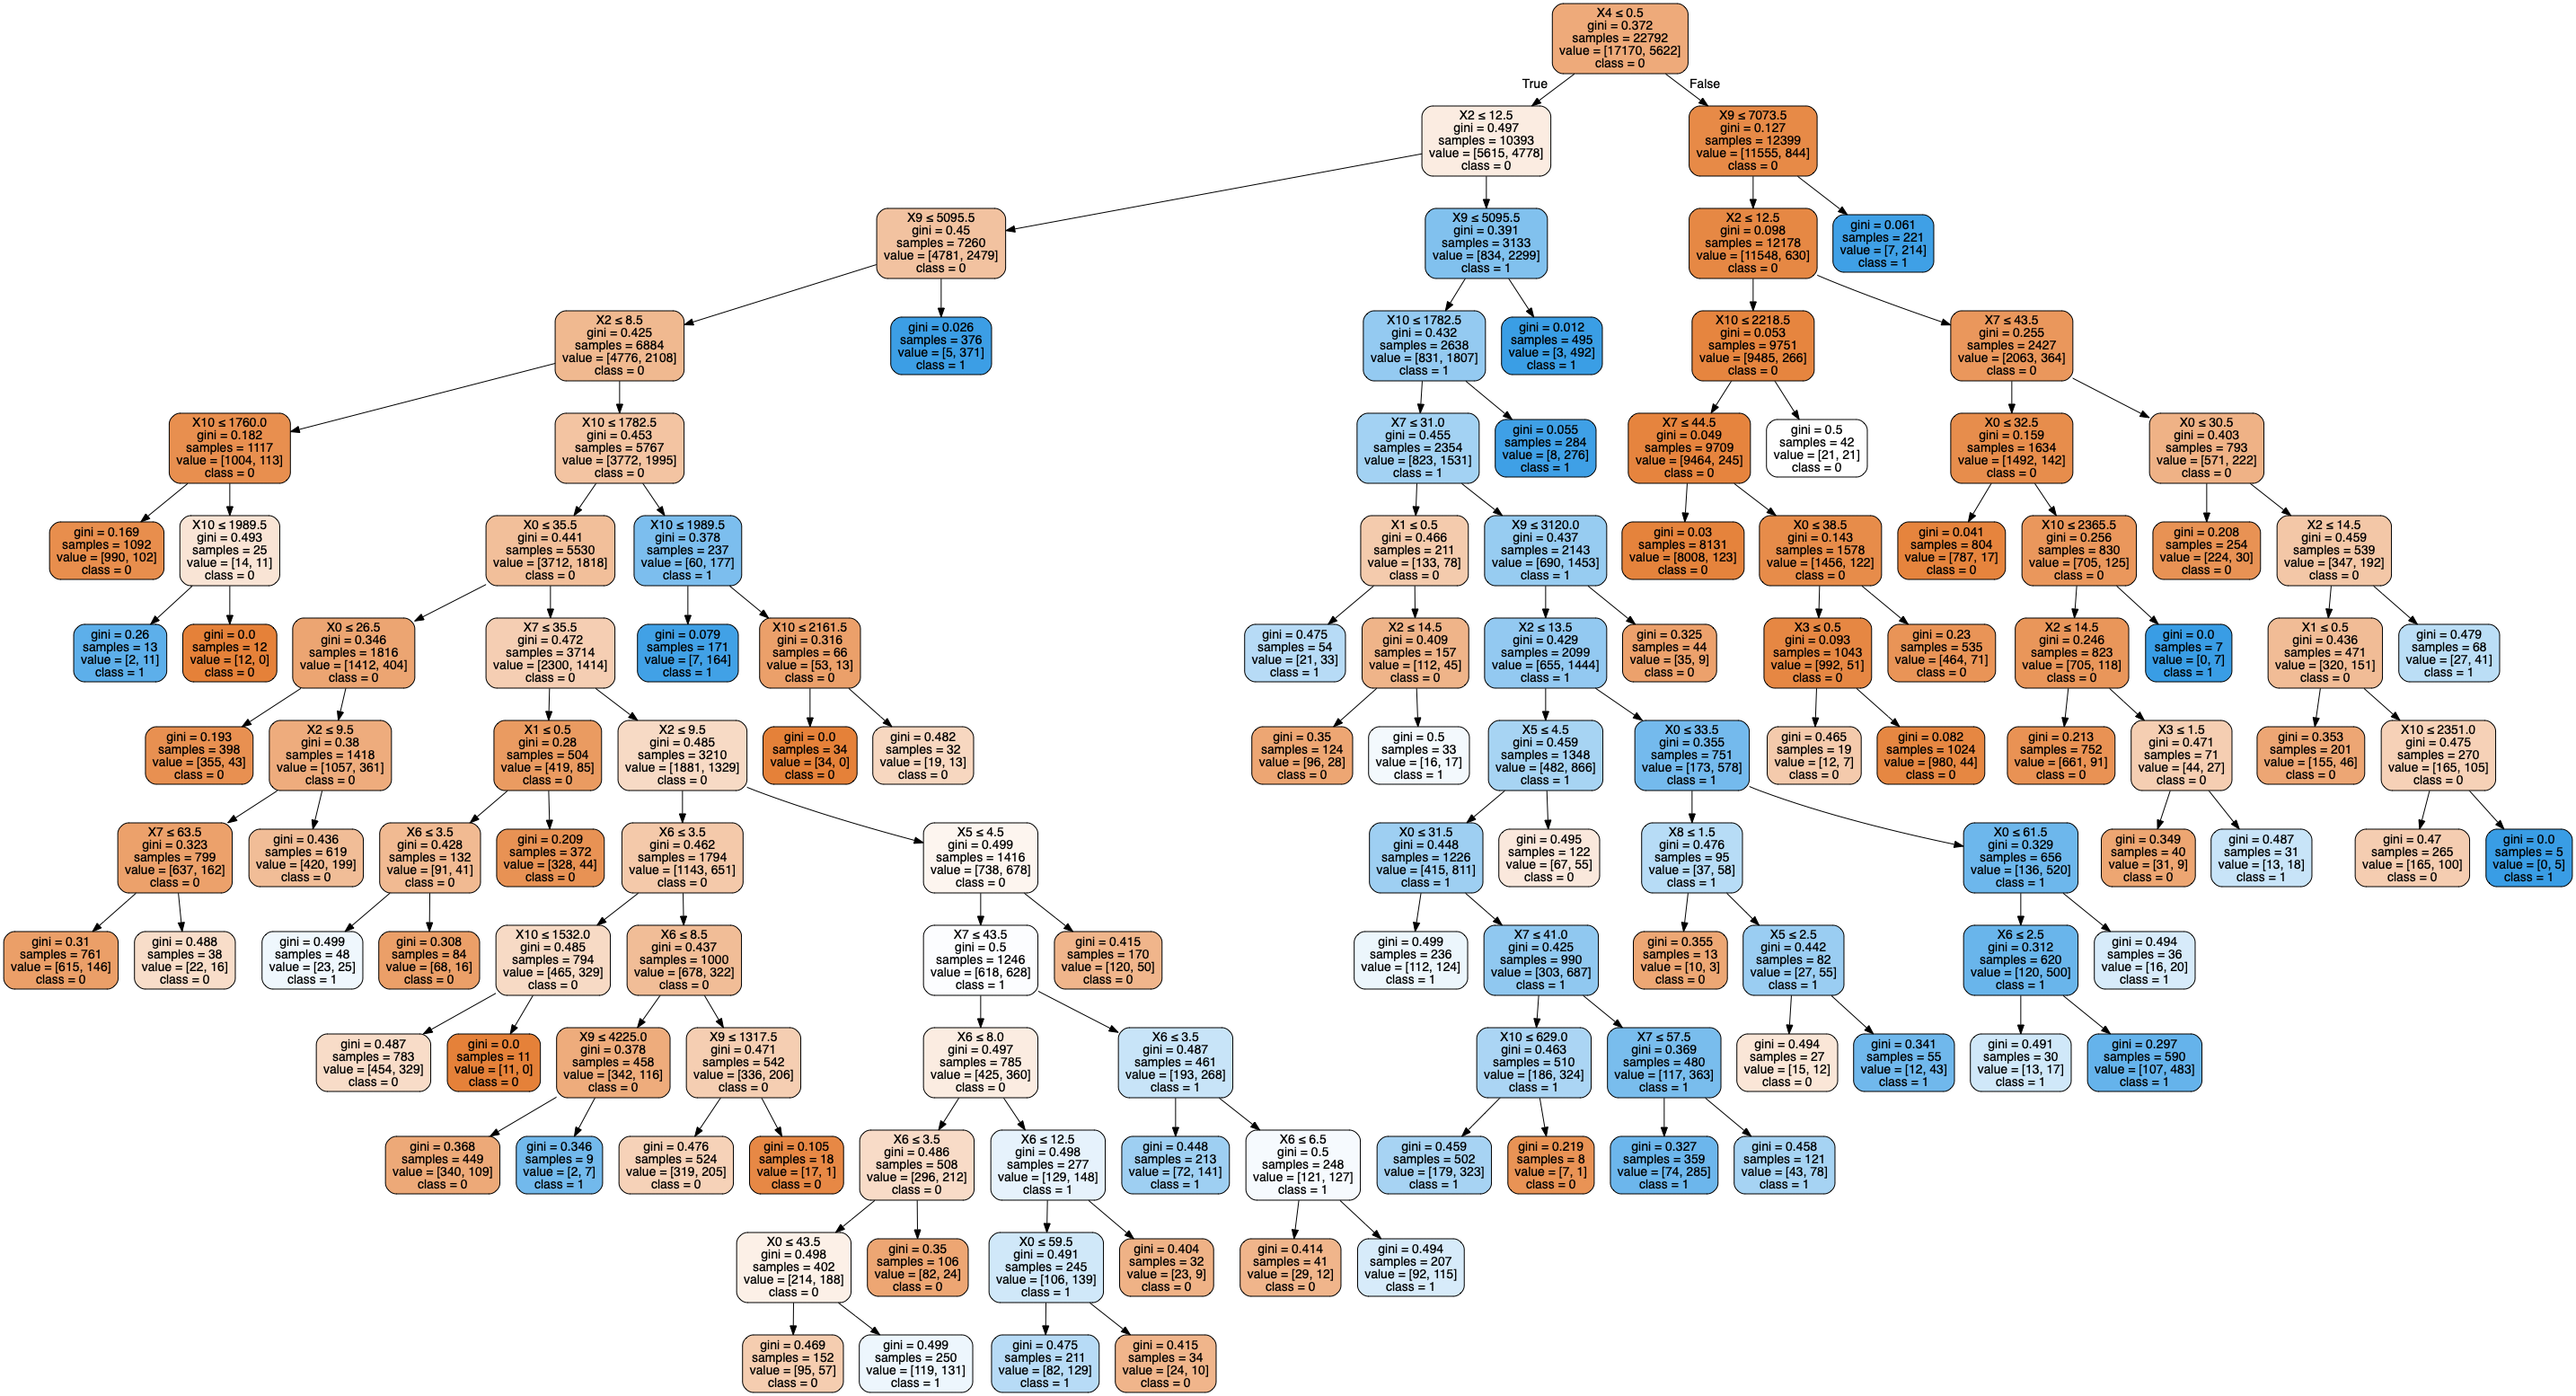

In [58]:
dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())